# embedding

## 词语义表征

自然语言处理的的首要目的是识别文本语义。

例如在新闻分类任务，对于文本“全红婵获得了跳水冠军”需要分类为“运动”类的新闻

如果以语义分析角度，通过提取“主谓宾“语法关系，发现名词 ”跳水“， 成为了分类成功的关键。

我们需要识别两种语义模式：

1. word-level : 即上述例子中，我们仅通过 “跳水” 词就能进行分类
2. context-level : 我们需要将文本中每个词进行相关性联系, 推导出分类

毫无疑问的是，word-level更简单，毕竟词的属性是 独立的，而 context-level 是复杂的，例如：

“小冬瓜真有两把刷子“ 中的 ”刷子“， 从 word-level 来看是具体的实体，而从 context-level 来看，“刷子” 代表的是抽象的 “能力”。

**本 notebook 从 word-level 角度展开 “word” 的表示，再到复杂的 “context” 级别的语义表征。**

## 词如何表示

token 可以通过向量表示（这是约定速成的方法），向量维度越高，那么蕴含的信息则越丰富。

表示通常有三种方法:

1. one-hot: 将离散数据 转化成 离散向量
2. embedding：将离散数据 转化成 连续向量
3. vector-quant：将连续数据 转化为 离散数据（ CV常用，本 lecture 不涉及）

### one-hot

对于词表中包含 5 个token : `{'i':1, 'love':2, 'cat':3, 'you':4, '!':5}`:

对于文本“I love you” 中的 三个 token （忽略空格），则可以用 `3x5` 矩阵表示，行代表 一个 one-hot 向量。

one-hot 概念是，**一个零向量里， 仅有一个维度有非零值。**

|      | I    | Love | Cat  | You  | !    |
| ---- | ---- | ---- | ---- | ---- | ---- |
| I    | 1    | 0    | 0    | 0    | 0    |
| Love | 0    | 1    | 0    | 0    | 0    |
| You  | 0    | 0    | 0    | 1    | 0    |

one-hot 问题在于, 主流语言的词表大小 `128,000` , 高维稀疏, 表示低效。

### one-hot pytorch

In [1]:
import torch
torch.manual_seed(42)

vocab_size = 7
seq_len = 4
batch_size = 2

x = torch.randint(0, vocab_size, (1, seq_len))
X = torch.randint(0, vocab_size, (batch_size, seq_len))
print(x)
print(X)

tensor([[1, 2, 4, 5]])
tensor([[4, 3, 5, 5],
        [0, 0, 0, 5]])


In [2]:
import torch.nn as nn
import torch.nn.functional as F

x = torch.randint(0, vocab_size, (1, seq_len))
one_hot = F.one_hot(x, num_classes= vocab_size)

print(x)
print(one_hot)

tensor([[6, 4, 1, 2]])
tensor([[[0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]]])


In [3]:
torch.arange(6)

tensor([0, 1, 2, 3, 4, 5])

In [4]:
# 手动实现
one_hot = torch.zeros(1, seq_len, vocab_size, dtype=torch.long)
print(one_hot)
one_hot[ :, torch.arange(seq_len).tolist() ,  x[0,:] ] = 1
print(one_hot)

tensor([[[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]])
tensor([[[0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]]])


### embedding

**embedding** 概念：将高维离散向量 “嵌入” 到低维“连续”向量，

embedding 在数学上是“操作”，在 NLP 里是指名词 “嵌入向量”， **word embedding** 是 **词嵌入向量** 或 **词嵌入**（嵌入/向量 两者意义重复，一般用“词嵌入”来表示向量）


我们仍以向量来表示词，相较于 one-hot 用离散方式来表示词信息，而 embedding 则以 **特征视角** 来表示词：

- “王“ 字，它有 ”姓氏“，”中文“，“名词”等属性；
- “瓜” 字，它有“植物”，“水果” “名词”，“中文”,"重量:3.4kg"等属性；
- “play” 字，它有 “动词”,"英文" 属性

显式的可以表示各个词元的属性, 其表示更丰富

|        | 姓氏 | 中文 | 名词 | 植物 | 水果 | 中文 | 重量 | 动词 | 英文 |
| ------ | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| `王`   | 1    | 1    | 1    | 0    | 0    | 0    | 0    | 0    | 0    |
| `瓜`   | 0    | 1    | 1    | 1    | 1    | 0    | 3.4  | 0    | 0    |
| `play` | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 1    | 1    |

对于瓜的 embedding 表示为 `[0, 1, 1, 1, 1, 0, 3.4, 0, 0]`


这种方式的问题是: 我们要手工设计多维特征表示, 因此我们要的 embedding 特性为

1. latent-feature 
2. 连续
3. 自动化特征表示

In [5]:
print(x)

tensor([[6, 4, 1, 2]])


In [6]:
# 手动实现: embedding 本质就是存储一个 行优先 的矩阵（随机数初始化, 每个词向量特征无意义）
# token_id 取对应的 行向量 作为 embedding 特征
dim = 5
E = torch.randn( vocab_size, dim ) # randn embedding 矩阵
print(E)

input_embd = E[ x[0,:], : ]
print(input_embd)

tensor([[ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581],
        [ 1.0783,  0.8008,  1.6806,  1.2791,  1.2964],
        [ 0.6105,  1.3347, -0.2316,  0.0418, -0.2516],
        [ 0.8599, -1.3847, -0.8712, -0.2234,  0.5258],
        [-0.4880,  1.1914, -0.8140, -0.7360, -0.8371],
        [-0.9224,  1.8113,  0.6756, -0.0978,  1.8446],
        [-1.1845,  1.3835, -1.2024,  0.7078, -1.0759]])
tensor([[-1.1845,  1.3835, -1.2024,  0.7078, -1.0759],
        [-0.4880,  1.1914, -0.8140, -0.7360, -0.8371],
        [ 1.0783,  0.8008,  1.6806,  1.2791,  1.2964],
        [ 0.6105,  1.3347, -0.2316,  0.0418, -0.2516]])


In [7]:
# pytorch 实现
embedding_layer = nn.Embedding(vocab_size, dim) # 参数是可以学习的
print(embedding_layer(x))

embedding_layer.weight.data = E.clone() # 用手动的 embedding 矩阵 初始化
print(embedding_layer(x)) # 与上一个矩阵格相等。

tensor([[[ 0.1233,  0.3499,  0.6173, -0.1693,  0.2332],
         [-0.4502, -0.6788,  0.5743,  0.1877, -0.3576],
         [ 0.1453,  0.2311,  0.0087,  0.4263,  0.5750],
         [-0.6417, -2.2064, -0.7508,  2.8140,  0.3598]]],
       grad_fn=<EmbeddingBackward0>)
tensor([[[-1.1845,  1.3835, -1.2024,  0.7078, -1.0759],
         [-0.4880,  1.1914, -0.8140, -0.7360, -0.8371],
         [ 1.0783,  0.8008,  1.6806,  1.2791,  1.2964],
         [ 0.6105,  1.3347, -0.2316,  0.0418, -0.2516]]],
       grad_fn=<EmbeddingBackward0>)


embedding layer 就当成是 模型的 一个输入层，随着梯度反向传播，能自然的调整嵌入层参数

注意：这种方式 embedding 表征了什么，完全由训练任务所决定。

## word2vec

上述的 embedding 是由随机初始化而来，是没有语义的。我们需要构建 **学习任务** 来对词进行表征

`word2vec` 是一种 无监督表征词向量的方法。建立假设：**相邻词之间有关联**

给定 "large language model is a helpful agent", 以中心词如 `Models` 找到 2-gram 左右的两个词元，假设为有关联词元，

|   中心词  | large | language | Models | is   | a    | helpful | Agent |
| -------- | ----- | -------- | ------ | ---- | ---- | ------- | ----- |
| Large    | 0     | 1        | 2      | -1   | -1   | -1      | -1    |
| Language | 1     | 0        | 1      | 2    | -1   | -1      | -1    |
| Models   | 2     | 1        | 0      | 1    | 2    | -1      | -1    |
| ....     |       |          |        |      |      |         |       |

注：0表示中心词，句子中的每个词都可以是一个中心词。 1,2 表示距离中心词的距离，-1表示无关，

构建任务，给定一个中心词，预测其向量词，具体如下：

- [vx] -> [vy] : [label]
- Models -> large : True
- Models -> language : True
- Models -> Models : True
- Models -> is : True
- Models -> a : True
- Models -> helpful : False
- Models -> agent : False

### 训练

In [8]:
w2v_seq_len = 100
x_c = torch.randint(0, vocab_size, size=(1, w2v_seq_len))[0] # 语料
X_c = E[ x_c, :] # 完整嵌入输入矩阵

In [9]:
# 计算两个word embedding 相关性
x_c 
print(E[x_c[2], :] @ E[x_c[0], :].t()) # 1-to-1
print(E[x_c[2], :] @ E.t()) # 1-to-n: logits
print(F.softmax(E[x_c[2], :] @ E.t(), dim = 0) ) # 1-to-n: prob
print(F.softmax(E[x_c[2], :] @ E.t(), dim = 0).sum() ) # 1-to-n: prob

tensor(-3.5814)
tensor([-3.5814,  3.8576,  1.2299, -2.8981,  0.5859,  8.0002,  0.7325])
tensor([9.1676e-06, 1.5595e-02, 1.1267e-03, 1.8156e-05, 5.9172e-04, 9.8197e-01,
        6.8509e-04])
tensor(1.)


In [10]:
# 创建数据集
gram = 2
dataset_x = []
dataset_y = []
for i in range(w2v_seq_len):
    left_id = i - gram 
    right_id = i + gram 
    if left_id < 0:
        left_id = 0
    if right_id >  w2v_seq_len:
        right_id = w2v_seq_len 
    for j in range(left_id, right_id + 1):
        if j != i and j < w2v_seq_len :
            dataset_x.append(x_c[i].item())
            dataset_y.append(x_c[j].item())
            
print(x_c[:5])
print(dataset_x[:10])
print(dataset_y[:10])

tensor([0, 3, 5, 4, 2])
[0, 0, 3, 3, 3, 5, 5, 5, 5, 4]
[3, 5, 0, 5, 4, 0, 3, 4, 2, 3]


In [11]:
import torch.optim as optim

lr = 0.01

if E.requires_grad is False:
    E.requires_grad = True

# 训练步骤
def train(center_words, target_words, model):
    # model.train()
    
    # 前向传播
    logits = model[center_words, :] @ model.t() # 完整数据集一次前向
    print(logits.shape) # n x vocab_size
    
    # 计算交叉熵损失
    label = torch.tensor(target_words, dtype = torch.long)
    loss = F.cross_entropy(logits, label)
    
    # 反向传播和优化
    loss.backward()
 
    model = model + lr * model.grad #optimizer.step()
    model.grad = torch.zeros_like( model )
    
    return loss.item(), model

print(E[0,:])
E.retain_grad()
print(len(dataset_x))
loss, E = train(dataset_x, dataset_y, E)
print(E[0,:])

tensor([ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581], grad_fn=<SliceBackward0>)
394
torch.Size([394, 7])
tensor([ 1.6451, -0.1610, -0.4975,  0.4404, -0.7592], grad_fn=<SliceBackward0>)


### 小结
同理， 对其他中心词可以相同手段处理，分析 word2vec:

1. 从大量语料中，无监督学习词元表征
2. vec 有语义
3. 其特征是面向词元表征的，静态的

示例的 word2vec 存在问题及优化（可选，不影响课程学习）

1. 存在重复前向计算：一个中心词前向计算，既可以得到 预测所有 word 的概率分布。可以复用概率分布。
2. 当 词表大时， 存在大型的矩阵运算，可以采用 **负采样策略** 来减少计算规模

## 文本语义表征

上述的词元表征是 token-level 的，其表示是序列无关的。

如何分析 token 序列语义？

1. word-level 分析: 如训练一个 分类模型，可以对 embedding 分类。 “跳“ embedding 可能被分为 ”新闻类“
2. context-level 分析：将序列 embedding 进行归并形成一个向量，如 $S =\sum_j^N X_j$

### 归并

对于 word2vec 的表示 是 token-level 的

归并特征我们可以视为 context-level 的

In [12]:

bs = 32
seq_len = 100
E = torch.randn(vocab_size, dim)
dim = E.shape[1]
print(dim)
input_ids = torch.randint(0, vocab_size, size=(bs, seq_len)) # 语料
X = E[input_ids.view(-1),:]
X = X.view(bs, seq_len, dim)

seq_embd = X.mean(dim = 1) # seq dimentsion mean
print(seq_embd.shape)

# 对于 batch = 32, 即 一个句子 由原来的 1x100x5 -> 1x5 表示，32个句子为 32x5

5
torch.Size([32, 5])


### 加权组合

"全红婵获得了跳水冠军", 明显 “跳“，”水”词元对 分类任务有更重要的贡献。

定义 权重$w_j$, 来组合词向量. $S =\sum_j^N w_j X_j$, $w_j \in R$

对于上述归并，权重实际上是一种特例。即权重 $S =\sum_j^N w_j X_j$, $w_j = 1/N$

In [13]:
seq = input_ids[0,:]
print(seq.shape)

X_0 = X[0,:,:]
print(X_0.shape)

weight = torch.randn(1, seq_len)
weight = F.softmax(weight, dim = 0)
print(weight.shape)

S = weight @ X_0 
print(S.shape)

torch.Size([100])
torch.Size([100, 5])
torch.Size([1, 100])
torch.Size([1, 5])


### 加权组合扩展

对于加权组合特征，我们用新的视角进行理解

如果对于每个 token， 都有一个独立的 $W \in \mathbb{R} ^{N \times N}$,  $W_i \in \mathbb{R} ^{1 \times N}$



即 $S_i \in \mathbb{R}^d$ 是蕴含 context 信息的 word-embedding

回到一开始的例子“小冬瓜真有两把刷子”, 对于 $S_\text{刷子}$ 即是含有 context-level 的表征。

In [14]:
seq = input_ids[0,:]
print(seq.shape)

X_0 = X[0,:,:]
print(X_0.shape)

weight = torch.randn(seq_len, seq_len)
weight = F.softmax(weight, dim = 1)
print(weight.shape)

S = weight @ X_0 
print(S.shape)
print(S[-1,:].shape) # final embedding as sentece-representation

torch.Size([100])
torch.Size([100, 5])
torch.Size([100, 100])
torch.Size([100, 5])
torch.Size([5])


### 循环神经网络(*)

RNN 类网络构造 $h_t = x_t + w h_{t-1} \in \mathbb{R}^{1 \times d}$, 在最终时刻有完整序列特征

In [15]:
import math
w_rnn = torch.randn(dim, dim) / math.sqrt(dim) # ignore bias
w_mlp = torch.randn(dim, dim) / math.sqrt(dim) 

In [16]:
h_t = torch.zeros(1, dim) 
print(h_t)
print(X_0[0,:])
for i in range(seq_len - 1) :
    h_t = 1/seq_len * X_0[i,:] + h_t @ w_rnn
    h_t = h_t @ w_mlp 
print(h_t)

tensor([[0., 0., 0., 0., 0.]])
tensor([ 0.7047, -0.0045,  1.6668, -1.0809, -0.7839])
tensor([[-0.0063, -0.0010, -0.0036,  0.0006, -0.0015]])


### 总结

序列特征是建立在词特征上进行一定规则的组合。

1. 归并：是一种“一视同仁”重要性的 组合特征方式, 其学习仅是在特征层面学习：$ h_j=X_jW$, $S =\sum_j^N h_j$
2. 加权组合：是一种关注“特征软选择”的组合方式，各个token的权重大小如何定义？如果其加权系数 $w_i,i=1,2,\ldots,N$ 是可学习参数，相较归并特征，增加一个维度序列的学习。它是 **注意力** 机制的核心思想。
3. 循环神经网络：是一种递增的学习表示，在计算上，串型特性使得计算效率低，且时序之间有依赖，不如以上两者直接。

至此，梳理了 文本 -> 分词 -> embedding -> 序列表征，的基础概念。

## 实例：基于 embedding 的文本分类

我们用加权组合方法来做文本分类

In [17]:
# 数据
bs = 32
seq_len = 100
dim = 512
vocab_size = 26
class_num = 3 # 情感分类: negative, neutral, positive


class SimplesLanguageModel(nn.Module):
    def __init__(self, dim = 512, vocab_size = 100, class_num = 2):
        super().__init__()
        self.dim = dim
        self.vocab_size = vocab_size
        self.class_num = class_num
        self.E = nn.Embedding(vocab_size, dim)
        self.w_feat = nn.Linear(dim, dim, bias = False)
        self.weight = nn.Linear(dim, 1)
        self.head = nn.Linear(dim, class_num)
        
    def forward(self, X):
        bs,seq_len = X.shape
        X = self.E(X)
        feat = self.w_feat(X)
        
        weight = self.weight(X) / seq_len

        h = weight.transpose(2,1) @ feat
        
        Y = self.head(h)
        return Y[:,0,:] # logits
        
input_ids = torch.randint(0, vocab_size, size=(bs, seq_len)) # 语料
Y = torch.randint(0, class_num, size=(1, bs))[0]

model = SimplesLanguageModel(dim, vocab_size, class_num)
E_init =  model.E.weight.data.clone()

optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

In [18]:
A = torch.randn(bs,seq_len,dim)
model.weight( A ).shape

torch.Size([32, 100, 1])

In [19]:
for i in range(1000):
    optimizer.zero_grad()
    Y_pred = model(input_ids)

    loss = loss_fn(Y_pred, Y)   
    if i % 100 == 0:
        print(loss)
    loss.backward()
    optimizer.step()

tensor(1.1033, grad_fn=<NllLossBackward0>)
tensor(0.8520, grad_fn=<NllLossBackward0>)
tensor(0.5856, grad_fn=<NllLossBackward0>)
tensor(0.2705, grad_fn=<NllLossBackward0>)
tensor(0.1069, grad_fn=<NllLossBackward0>)
tensor(0.0496, grad_fn=<NllLossBackward0>)
tensor(0.0284, grad_fn=<NllLossBackward0>)
tensor(0.0187, grad_fn=<NllLossBackward0>)
tensor(0.0135, grad_fn=<NllLossBackward0>)
tensor(0.0103, grad_fn=<NllLossBackward0>)


In [20]:
model.E.weight.data
print(model.E.weight.data.shape)

torch.Size([26, 512])


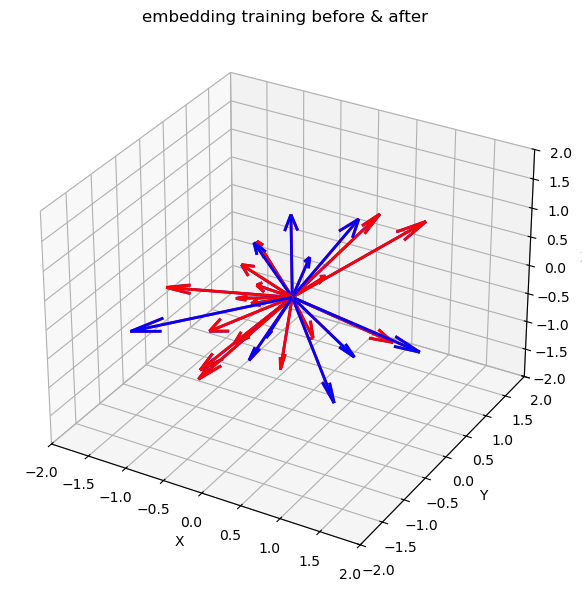

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

embds = model.E.weight.data[:, :3].tolist()
embds_init =  E_init[:, :3].tolist()

for emb in embds:
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              # length=1.0, 
              normalize=False,   # 不自动归一化
              arrow_length_ratio=0.2,
              color='blue',
              linewidth=2)
for emb in embds_init:  
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2],
              # length=1.0, 
              normalize=False,   # 不自动归一化
              arrow_length_ratio=0.2,
              color='red',
              linewidth=2)


max_range = 2
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('embedding training before & after')


plt.tight_layout()
plt.show()

## 手撕 word2vec backward(*)

In [22]:
bs = 1
seq_len = 10
dim = 8
vocab_size = 10
class_num = 3 
dim_out = 9


E = torch.randn(vocab_size, dim, requires_grad=True) #vocab,dim
x = torch.randint(1, vocab_size, (1, seq_len))[0]
label = torch.randn(1, dim_out)
print(x)
W = torch.randn(dim, dim_out)

tensor([2, 6, 5, 8, 8, 6, 3, 7, 3, 9])


### 前向

In [23]:

X = E[x, :]
Y = X @ W
loss = 1/Y.numel() * (( Y - label) ** 2).sum() # MSE
print(loss)

tensor(11.2082, grad_fn=<MulBackward0>)


### 反向手撕

In [26]:
# 反向
dL = 1/Y.numel() * 2 * (Y-label) # v x dim_out
dW = X.t() @ dL 
dX = dL @ W.t() 

dE = torch.zeros(vocab_size, dim)
count = torch.zeros(vocab_size)
for i in range(seq_len):
    dE[x[i],:] += dX[i,:]
    count[x[i]] += 1
print(dE)
print(count)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0839, -0.3267,  0.2876,  0.2341, -0.0161,  0.1066, -0.2251,  0.1010],
        [ 0.0974,  0.0185,  0.3946, -0.5369,  2.0574,  0.0371,  0.5798, -0.0689],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1528,  0.3471,  0.0613, -0.6406,  1.6349, -0.0322,  0.5356, -0.1548],
        [ 0.1550,  0.1463,  0.5918, -0.3881,  0.6567,  0.0222, -0.6419,  0.0646],
        [ 0.1846, -0.0783, -0.0672,  0.4621, -0.5657,  0.0907,  0.1340, -0.0648],
        [ 0.3269, -0.9483,  0.8777,  0.0086,  1.0326,  0.1579, -0.2795,  0.5369],
        [ 0.0914,  0.2303, -0.0826,  0.1685,  0.0571,  0.0797,  0.3166, -0.1854]],
       grad_fn=<CopySlices>)
tensor([0., 0., 1., 2., 0., 1., 2., 1., 2., 1.])


### 反向-by-pytorch autograd

In [27]:
# pytorch 自动求导
X = E[x, :]
Y = X @ W
loss_fn = nn.MSELoss()
loss = loss_fn(Y, label)
print(loss)
loss.backward()
E.grad

tensor(11.2082, grad_fn=<MseLossBackward0>)


/opt/homebrew/Caskroom/miniconda/base/envs/xr1/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 9])) that is different to the input size (torch.Size([10, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0839, -0.3267,  0.2876,  0.2341, -0.0161,  0.1066, -0.2251,  0.1010],
        [ 0.0974,  0.0185,  0.3946, -0.5369,  2.0574,  0.0371,  0.5798, -0.0689],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1528,  0.3471,  0.0613, -0.6406,  1.6349, -0.0322,  0.5356, -0.1548],
        [ 0.1550,  0.1463,  0.5918, -0.3881,  0.6567,  0.0222, -0.6419,  0.0646],
        [ 0.1846, -0.0783, -0.0672,  0.4621, -0.5657,  0.0907,  0.1340, -0.0648],
        [ 0.3269, -0.9483,  0.8777,  0.0086,  1.0326,  0.1579, -0.2795,  0.5369],
        [ 0.0914,  0.2303, -0.0826,  0.1685,  0.0571,  0.0797,  0.3166, -0.1854]])